In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline  


In [33]:
from hogares import EncuestaHogares

encuesta = EncuestaHogares("usu_hogar_T324.xlsx", "usu_individual_T324.xlsx")
hogares, personas = encuesta.memoria()
hogares, personas = encuesta.filtrados_por_region(43, hogares, personas)
subconjunto_hogares, subconjunto_personas = encuesta.subconjunto_columnas(hogares, personas)
subconjunto_hogares_personas = encuesta.df_hogares_personas(subconjunto_hogares, subconjunto_personas)

### Edad
Cuantitativa discreta

In [34]:
personas["edad"].describe()

count    14315.000000
mean        37.251764
std         22.394482
min         -1.000000
25%         18.000000
50%         35.000000
75%         55.000000
max        102.000000
Name: edad, dtype: float64

#### Valores Faltantes/Incorrectos
Hay 101 personas con edad -1.

In [35]:
len(personas[(personas["edad"]==-1)])

101

Se evalúa la fecha de nacimiento

In [36]:
estado = pd.DataFrame([
    (0, "Encuesta no realizada"),
    (1, "Ocupado"),
    (2, "Desocupado"),
    (3, "Inactivo"),
    (4, "Menor de 10 años")
], columns=["estado_actividad", "estado_nombre"])

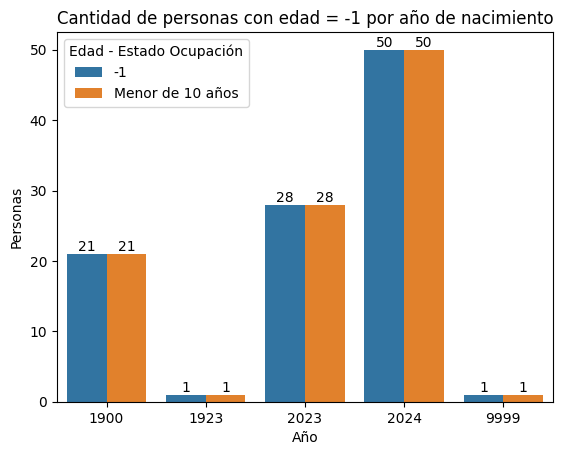

In [7]:
pd.options.mode.copy_on_write = True
ocurrencias_por_anio = pd.merge(personas[personas["edad"]==-1][["edad", "CH05", "estado_actividad"]], estado, on="estado_actividad")
ocurrencias_por_anio.loc[:, "año"] = ocurrencias_por_anio["CH05"].apply(lambda dt: dt.year)
ocurrencias_por_anio = pd.melt(ocurrencias_por_anio, id_vars=['año', "CH05", "estado_actividad"])
ocurrencias_por_anio

g = sns.countplot(data=ocurrencias_por_anio,  x="año", hue="value")
for i in g.containers:
    g.bar_label(i,)
g = g.set(xlabel='Año', ylabel='Personas')
g = plt.legend(title='Edad - Estado Ocupación', loc='upper left')
g = plt.title("Cantidad de personas con edad = -1 por año de nacimiento")


Se reemplazan los -1 por 0 asumiendo que las fechas de nacimiento correspondientes a los años 1900, 1923 y 9999 son errores de carga.

In [37]:
personas.loc[personas["edad"] == -1, "edad"] = 0

Se grafican la distribución de edades como histograma

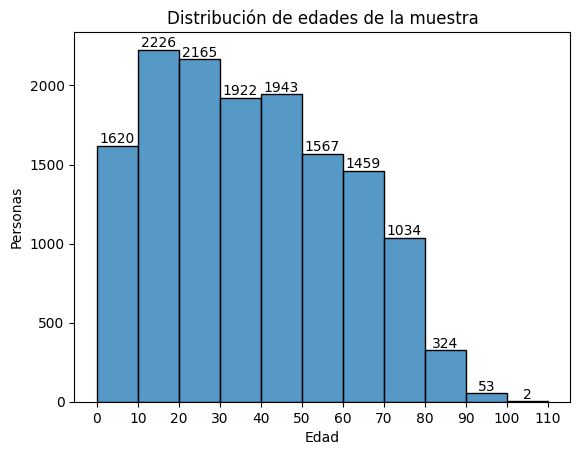

In [38]:
import matplotlib.ticker as ticker
fig, ax = plt.subplots()
g = sns.histplot(data=personas, x="edad", binwidth=10, ax=ax)
for i in g.containers:
    g.bar_label(i,)
g.xaxis.set_major_locator(ticker.MultipleLocator(10))
g = g.set(xlabel='Edad', ylabel='Personas')
plt.title("Distribución de edades de la muestra")
plt.show()

#### Relación Edad - Estado actividad 
Se agregan categorías cada $200.000

# Transformación de la Variable Ingreso
Se reemplazan los valores nulos, causados por la encuesta no realizada, por la mediana y no se consideran las no respuestas de ingresos 2411.

In [39]:
len(personas[personas["ingreso"]==-9])

2411

In [40]:
personas.loc[personas["ingreso"].isnull(), "ingreso"] = personas[personas["ingreso"]!=-9]["ingreso"].median()

In [41]:
personas["ingreso"].isnull().sum()

0

#### Ingresos por Edad 

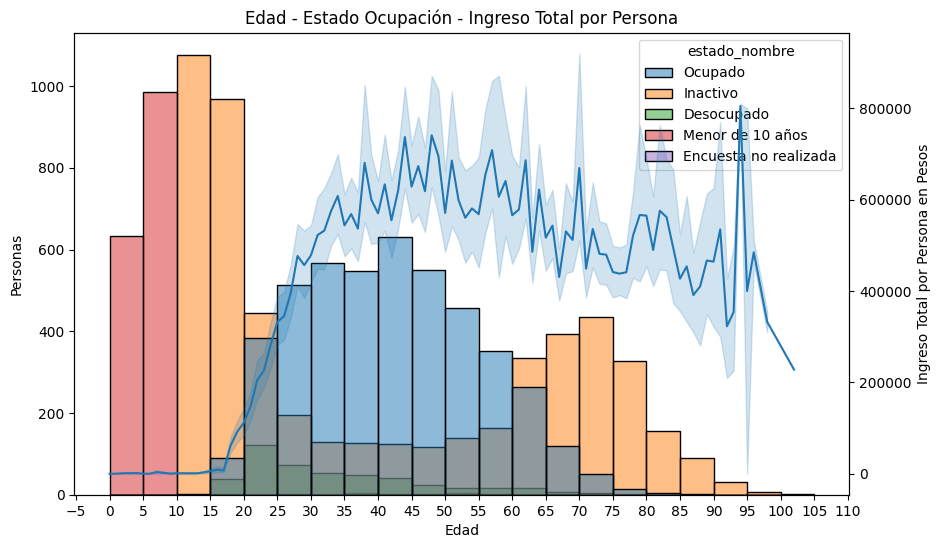

In [42]:
fig, ax = plt.subplots(figsize=(10,6))
personas_estado = pd.merge(personas[personas["ingreso"]!=-9], estado, on="estado_actividad")
g = sns.histplot(data=personas_estado, x="edad", binwidth=5, ax=ax, hue="estado_nombre")

# for i in g.containers:
#     g.bar_label(i,)
g.xaxis.set_major_locator(ticker.MultipleLocator(5))
# g._legend.set_title('Estado actividad')
ax.set(xlabel='Edad', ylabel='Personas')

ax2 = ax.twinx()  
sns.lineplot(data=personas_estado, x="edad", y="ingreso", ax=ax2)
ax2.set(ylabel='Ingreso Total por Persona en Pesos')
plt.title("Edad - Estado Ocupación - Ingreso Total por Persona")
plt.show()

#### Categorización de Variable Ingresos

In [49]:
personas.loc[personas["ingreso"]==0, "Rango Ingresos"] = "Sin Ingreso"
personas.loc[(personas["ingreso"]>0)&(personas["ingreso"]<=200000), "Rango Ingresos"] = "0 - 200k"
personas.loc[(personas["ingreso"]>200000)&(personas["ingreso"]<=400000), "Rango Ingresos"] = "200 - 400k"
personas.loc[(personas["ingreso"]>400000)&(personas["ingreso"]<=600000), "Rango Ingresos"] = "400 - 600k"
personas.loc[(personas["ingreso"]>600000)&(personas["ingreso"]<=800000), "Rango Ingresos"] = "600 - 800k"
personas.loc[(personas["ingreso"]>800000)&(personas["ingreso"]<=1000000), "Rango Ingresos"] = "800k - 1m"
personas.loc[(personas["ingreso"]>1000000)&(personas["ingreso"]<=2000000), "Rango Ingresos"] = "1m - 2m"
personas.loc[(personas["ingreso"]>2000000)&(personas["ingreso"]<=3000000), "Rango Ingresos"] = "2m - 3m"
personas.loc[(personas["ingreso"]>3000000), "Rango Ingresos"] = "+3m"

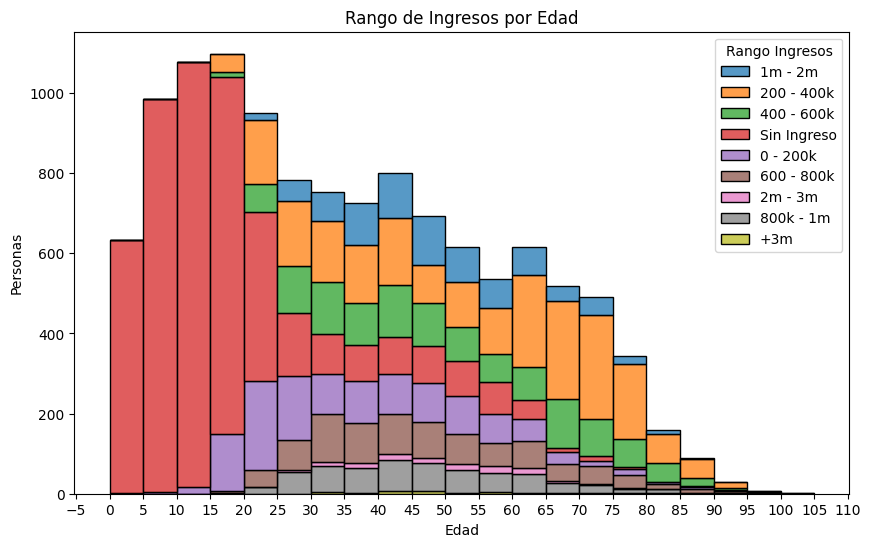

In [50]:
fig, ax = plt.subplots(figsize=(10,6))
g = sns.histplot(data=personas, x="edad", binwidth=5, ax=ax, hue="Rango Ingresos", multiple="stack")

# for i in g.containers:
#     g.bar_label(i,)
g.xaxis.set_major_locator(ticker.MultipleLocator(5))
# g._legend.set_title('Estado actividad')
ax.set(xlabel='Edad', ylabel='Personas')
plt.title("Rango de Ingresos por Edad")
plt.show()

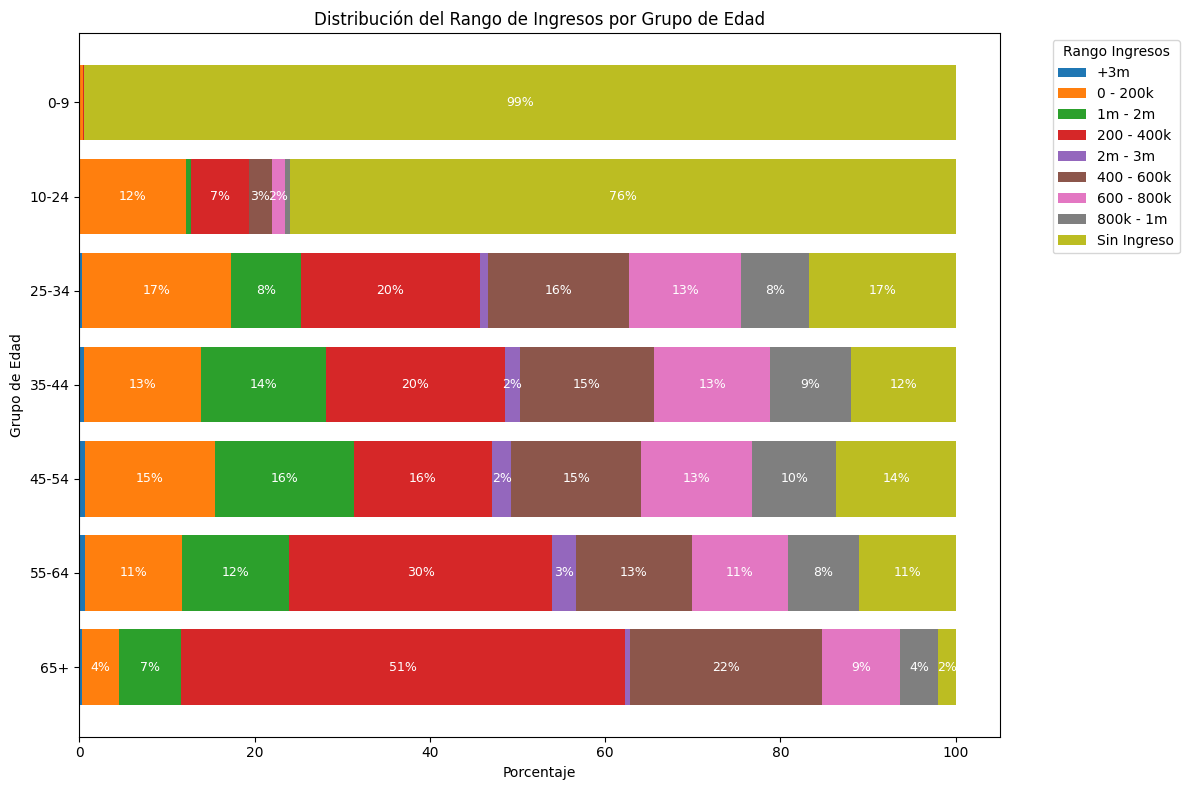

In [51]:
bins = [0, 10, 25, 35, 45, 55, 65, 100]
labels = ["0-9", "10-24", "25-34", "35-44", "45-54", "55-64", "65+"]
#personas = personas[personas["edad"] >= 10] 
personas["Grupo Edad"] = pd.cut(personas["edad"], bins=bins, labels=labels, right=False)

tabla = personas.groupby(["Grupo Edad", "Rango Ingresos"]).size().unstack(fill_value=0)
tabla_pct = tabla.div(tabla.sum(axis=1), axis=0) * 100

tabla_pct = tabla_pct[::-1]

fig, ax = plt.subplots(figsize=(12, 8))
left = [0] * len(tabla_pct)

for col in tabla_pct.columns:
    vals = tabla_pct[col]
    bars = ax.barh(tabla_pct.index, vals, left=left, label=col)

    for bar, val in zip(bars, vals):
        if val > 1:
            ax.text(bar.get_x() + bar.get_width() / 2,
                    bar.get_y() + bar.get_height() / 2,
                    f'{val:.0f}%', ha='center', va='center', color='white', fontsize=9)
    
    left = [l + v for l, v in zip(left, vals)]

ax.set_xlabel("Porcentaje")
ax.set_ylabel("Grupo de Edad")
ax.set_title("Distribución del Rango de Ingresos por Grupo de Edad")
ax.legend(title="Rango Ingresos", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

No aporta mucho las edades de menores de 10, podríamos seguir con mayores de 10 (ya también es otra categoria de Ocupacion menores de 10). Cambié los rangos, para acortarlos en sin ingresos, bajos, medios y altos.

In [59]:
personas.loc[personas["ingreso"]==0, "Rango Ingresos2"] = "Sin Ingreso"
personas.loc[(personas["ingreso"]>0)&(personas["ingreso"]<=400000), "Rango Ingresos2"] = "Bajos: 0 - 400k"
personas.loc[(personas["ingreso"]>400000)&(personas["ingreso"]<=1000000), "Rango Ingresos2"] = "Medios: 800 - 1m"
personas.loc[(personas["ingreso"]>1000000), "Rango Ingresos2"] = "Altos y muy altos: +1m"

orden = ["Sin Ingreso", "Bajos: 0 - 400k", "Medios: 800 - 1m", "Altos y muy altos: +1m"]
personas["Rango Ingresos2"] = pd.Categorical(personas["Rango Ingresos2"], categories=orden, ordered=True)

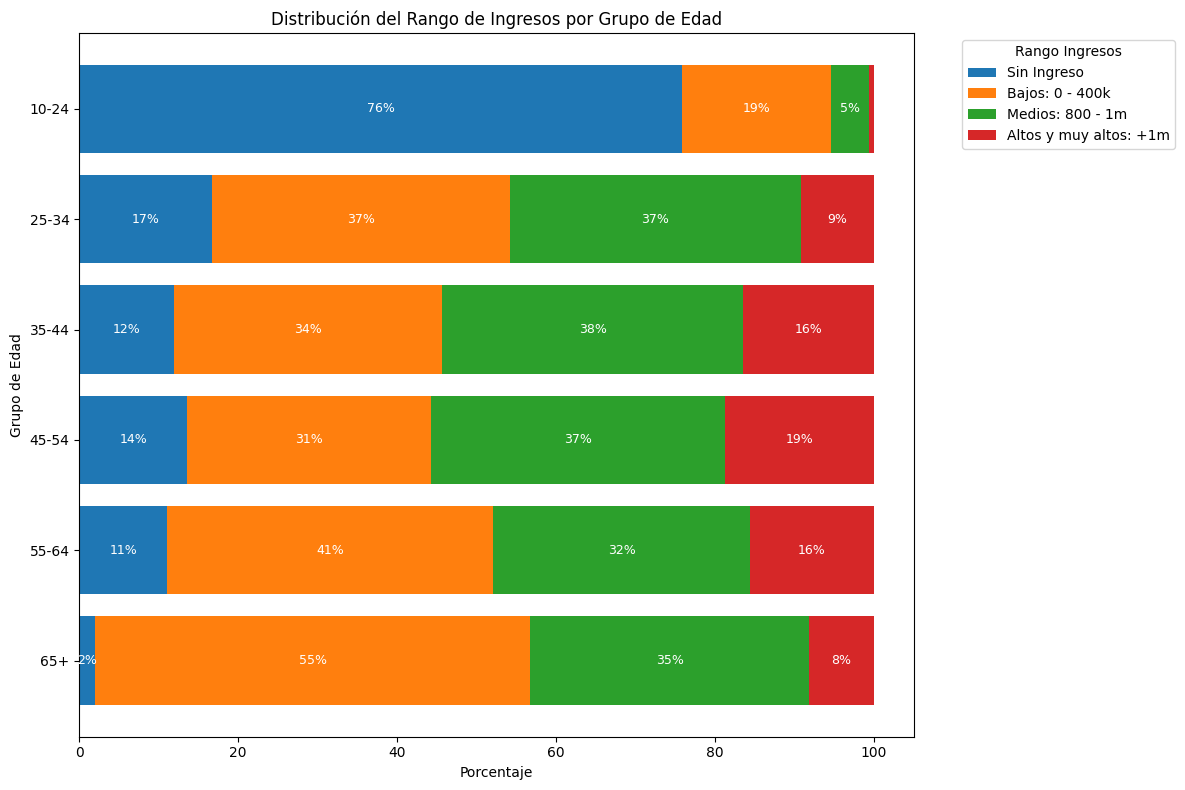

In [60]:
bins = [10, 25, 35, 45, 55, 65, 100]
labels = [ "10-24", "25-34", "35-44", "45-54", "55-64", "65+"]
personas = personas[personas["edad"] >= 10] 
personas["Grupo Edad"] = pd.cut(personas["edad"], bins=bins, labels=labels, right=False)

tabla = personas.groupby(["Grupo Edad", "Rango Ingresos2"]).size().unstack(fill_value=0)
tabla_pct = tabla.div(tabla.sum(axis=1), axis=0) * 100

tabla_pct = tabla_pct[::-1]

fig, ax = plt.subplots(figsize=(12, 8))
left = [0] * len(tabla_pct)

for col in tabla_pct.columns:
    vals = tabla_pct[col]
    bars = ax.barh(tabla_pct.index, vals, left=left, label=col)

    for bar, val in zip(bars, vals):
        if val > 1:
            ax.text(bar.get_x() + bar.get_width() / 2,
                    bar.get_y() + bar.get_height() / 2,
                    f'{val:.0f}%', ha='center', va='center', color='white', fontsize=9)
    
    left = [l + v for l, v in zip(left, vals)]

ax.set_xlabel("Porcentaje")
ax.set_ylabel("Grupo de Edad")
ax.set_title("Distribución del Rango de Ingresos por Grupo de Edad")
ax.legend(title="Rango Ingresos", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()